This work is grealy inspired of the work of Song et al, available [here](https://ieeexplore.ieee.org/document/8320798). The implementation is inspired and by the following [article](https://theaisummer.com/graph-convolutional-networks/) 

### Data exploration and explanation

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd 
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Since there are already calculated, in this notebook we will only work with the extracted features

In [3]:
import os
path2 = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
list_mat_ex = os.listdir(path2)
with open(path2 + '\\' + 'readme.txt') as readme :
    for line in readme:
        print(line)
readme.close()
#list_mat_ex.remove('readme.txt')
#list_mat_file contains all interessant files for our research
list_mat_ex.remove('readme.txt')
#list_mat_file contains all interessant files for our research
#list_mat_ex

For more detailed description of this dataset, please see http://bcmi.sjtu.edu.cn/~seed/



If you use this dataset, please cite the following paper:

"Investigating Critical Frequency Bands and Channels for EEG-based Emotion Recognition with Deep Neural Networks", Wei-Long Zheng, and Bao-Liang Lu, IEEE Transactions on Autonomous Mental Development (IEEE TAMD), 2015.


In [4]:
ex = list_mat_ex[0]
print(ex)
data_ex = loadmat(path2 +'\\' + ex)
print(data_ex.keys())

10_20131130.mat
dict_keys(['__header__', '__version__', '__globals__', 'de_movingAve1', 'de_LDS1', 'psd_movingAve1', 'psd_LDS1', 'dasm_movingAve1', 'dasm_LDS1', 'rasm_movingAve1', 'rasm_LDS1', 'asm_movingAve1', 'asm_LDS1', 'dcau_movingAve1', 'dcau_LDS1', 'de_movingAve2', 'de_LDS2', 'psd_movingAve2', 'psd_LDS2', 'dasm_movingAve2', 'dasm_LDS2', 'rasm_movingAve2', 'rasm_LDS2', 'asm_movingAve2', 'asm_LDS2', 'dcau_movingAve2', 'dcau_LDS2', 'de_movingAve3', 'de_LDS3', 'psd_movingAve3', 'psd_LDS3', 'dasm_movingAve3', 'dasm_LDS3', 'rasm_movingAve3', 'rasm_LDS3', 'asm_movingAve3', 'asm_LDS3', 'dcau_movingAve3', 'dcau_LDS3', 'de_movingAve4', 'de_LDS4', 'psd_movingAve4', 'psd_LDS4', 'dasm_movingAve4', 'dasm_LDS4', 'rasm_movingAve4', 'rasm_LDS4', 'asm_movingAve4', 'asm_LDS4', 'dcau_movingAve4', 'dcau_LDS4', 'de_movingAve5', 'de_LDS5', 'psd_movingAve5', 'psd_LDS5', 'dasm_movingAve5', 'dasm_LDS5', 'rasm_movingAve5', 'rasm_LDS5', 'asm_movingAve5', 'asm_LDS5', 'dcau_movingAve5', 'dcau_LDS5', 'de_movin

In [5]:
data_example = data_ex['de_movingAve2']
data_example.shape

(62, 233, 5)

### Initialization of the adjency matrix

In [6]:
#useless functions for the moment
def normalized_laplacian(W, multifreq = True):
    #L_norm = D^{-1/2}LD^{1/2} = I - D^{-1/2}AD^{1/2} in theory
    D_sqrt = torch.zeros_like(W)
    L_norm = torch.zeros_like(W)
    if multifreq:
        for freq in range(W.shape[0]):
            for i in range(W.shape[1]):
                d = torch.sum(W[freq, i, :]).item()
                D_sqrt[freq, i, i] = d**(1/2)
            L_norm[freq, :, :] = torch.eye(W.shape[1]) - torch.matmul(torch.matmul(D_sqrt[freq, :, :], W[freq, :, :]),
                                                                      D_sqrt[freq, :, :])
    else :
        for i in range(W.shape[0]):
            d = torch.sum(W[ i, :]).item()
            D_sqrt[i, i] = d**(1/2)
        L_norm = torch.eye(W.shape[0]) - torch.matmul(torch.matmul(D_sqrt, W), D_sqrt)
    return L_norm

def norm_mod_laplacian(W, multifreq = True):
    #L_norm_mod = D^{-1/2}(A + I)D^{1/2} in real life this is this expression that we use during the training
    #because it solves some instability issues
    D_sqrt = torch.zeros_like(W)
    L_mod = torch.zeros_like(W)
    if multifreq:
        for freq in range(W.shape[0]):
            for i in range(W.shape[1]):
                d = torch.sum(W[freq, i, :]).item()
                D_sqrt[freq, i, i] = d**(1/2)
            L_mod[freq, :, :] = torch.matmul(torch.matmul(D_sqrt[freq, :, :], (W[freq, :, :] + torch.eye(W.shape[1]))), 
                                              D_sqrt[freq, :, :])
    else :
        for i in range(W.shape[0]):
            d = torch.sum(W[i, :]).item()
            D_sqrt[i, i] = d**(1/2)
        L_mod[freq, :, :] = torch.matmul(torch.matmul(D_sqrt, (W + torch.eye(W.shape[0]))), D_sqrt)
    return L_mod

def rescaled_laplacian(L, multifreq = True): 
    #the normalization of the Laplacian in the paper is not the same that the general definition
    #that's why we names it rescaled Laplacian and not normalized one
    L_tilde = torch.zeros_like(L)  
    if multifreq: 
        for freq in range(L.shape[0]):
            with torch.no_grad(): 
                eigenvalues, eigenvectors = torch.linalg.eig(L[freq, :, :])
                eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
                max_lambda = torch.max(eigenvalues).item() 
            L_hat = ((2*L[freq, :, :]) / max_lambda) - torch.eye(L.shape[1])
            L_tilde[freq, :, :] = L_hat
    else :
        eigenvalues, eigenvectors = torch.linalg.eig(L)
        eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
        max_lambda = torch.max(eigenvalues).item() 
        L_hat = ((2*L) / max_lambda) - torch.eye(L.shape[0])
        L_tilde = L_hat
    return L_tilde





![alt text](EEGChannelPicture.PNG "Channel")

In [7]:
import pandas as pd
channel = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 
                'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6','FT8','T7','C5','C3','C1',
                'CZ','C2','C4','C6', 'T8','TP7','CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8','P7',
                'P5','P3','P1','PZ','P2','P4','P6','P8','PO7','PO5','PO3','POZ','PO4','PO6','PO8','CB1',
                'O1','OZ','O2','CB2']
idx = np.arange(62)
df_channel = pd.DataFrame({'idx': idx, 'channel': channel })

#initialization of the adjency matrix
feature_number = data_example.shape[0]
W = np.zeros((5, feature_number, feature_number))
for freq in range(5):
    #I don't see other way than initialiazing W manually
    #was done accodingly to the EEG channel map and order, hope to don't have make mistake
    #FP1
    W[freq, 0, 1] = 1
    W[freq, 0, 3] = 1
    #FPZ
    W[freq, 1, 0] = 1
    W[freq, 1, 2] = 1
    #FP2
    W[freq, 2, 1] = 1
    W[freq, 2, 4] = 1
    #AF3
    W[freq, 3, 8] = 1
    W[freq, 3, 7] = 1
    W[freq, 3, 6] = 1
    W[freq, 3, 0] = 1
    #AF4
    W[freq, 4, 2] = 1
    W[freq, 4, 10] = 1
    W[freq, 4, 11] = 1
    W[freq, 4, 12] = 1
    #F7
    W[freq, 5, 6] = 1
    W[freq, 5, 14] = 1
    #F5
    W[freq, 6, 3] = 1
    W[freq, 6, 5] = 1
    W[freq, 6, 15] = 1
    W[freq, 6, 7] = 1
    #F3
    W[freq, 7, 3] = 1
    W[freq, 7, 8] = 1
    W[freq, 7, 16] = 1
    #F1
    W[freq, 8, 9] = 1
    W[freq, 8, 17] = 1
    #FZ
    W[freq, 9, 10] = 1
    W[freq, 9, 18] = 1
    #F2
    W[freq, 10, 11] = 1
    W[freq, 10, 19] = 1
    #F4
    W[freq, 11, 12] = 1
    W[freq, 11, 20] = 1
    #F6 
    W[freq, 12, 13] = 1
    W[freq, 12, 21] = 1
    #F8
    W[freq, 13, 22] = 1
    #FT7
    W[freq, 14, 15] = 1
    W[freq, 14, 23] = 1
    #FC5 to TP8
    for k in range(15, 41): #till TP8 (number 40) we have two new neigbors: on the right and under +1 and +9 (nine electrodes per line)
        if k == 22 or k == 31 or k == 40 :
            W[freq, k, k+9] = 1
        else:
            W[freq, k, k+1] = 1
            W[freq, k, k+9] = 1
    #P7
    W[freq, 41, 42] = 1
    W[freq, 41, 50] = 1
    #P5
    W[freq, 42, 43] = 1
    W[freq, 42, 51] = 1
    #P3
    W[freq, 43, 44] = 1
    #P1
    W[freq, 44, 45] = 1
    W[freq, 44, 52] = 1
    #PZ
    W[freq, 45, 46] = 1
    W[freq, 45, 53] = 1
    #P2
    W[freq, 46, 47] = 1
    W[freq, 46, 54] = 1
    #P4
    W[freq, 47, 48] = 1
    #P6
    W[freq, 48, 49] = 1
    W[freq, 48, 55] = 1
    #P8
    W[freq, 49, 56] = 1
    #PO7
    W[freq, 50, 51] = 1
    W[freq, 50, 57] = 1
    #PO5
    W[freq, 51, 52] = 1
    W[freq, 50, 57] = 1
    #PO3
    W[freq, 52, 53] = 1
    W[freq, 52, 58] = 1
    #POZ
    W[freq, 53, 54] = 1
    W[freq, 53, 59] = 1
    #PO4
    W[freq, 54, 55] = 1
    W[freq, 54, 60] = 1
    #PO6
    W[freq, 55, 56] = 1
    W[freq, 55, 61] = 1
    #PO8
    W[freq, 56, 61] = 1
    #CB1
    W[freq, 57, 58] = 1
    #O1
    W[freq, 58, 59] = 1
    #OZ
    W[freq, 59, 60] = 1
    #O2
    W[freq, 60, 61] = 1

for freq in range(5):
    for i in range(feature_number):
        for j in range(i, feature_number):
            if W[freq, j, i] == 0:
                W[freq, j, i] = W[freq, i, j]

#for some training stability reasons we initialized the diagonal of W with 1
for freq in range(5):
    W[freq, :, :] = W[freq, :, :] + np.eye(W.shape[1], dtype=int)
print(W[0])   
print(np.transpose(W[0]) == W[0])
W = torch.from_numpy(W)

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


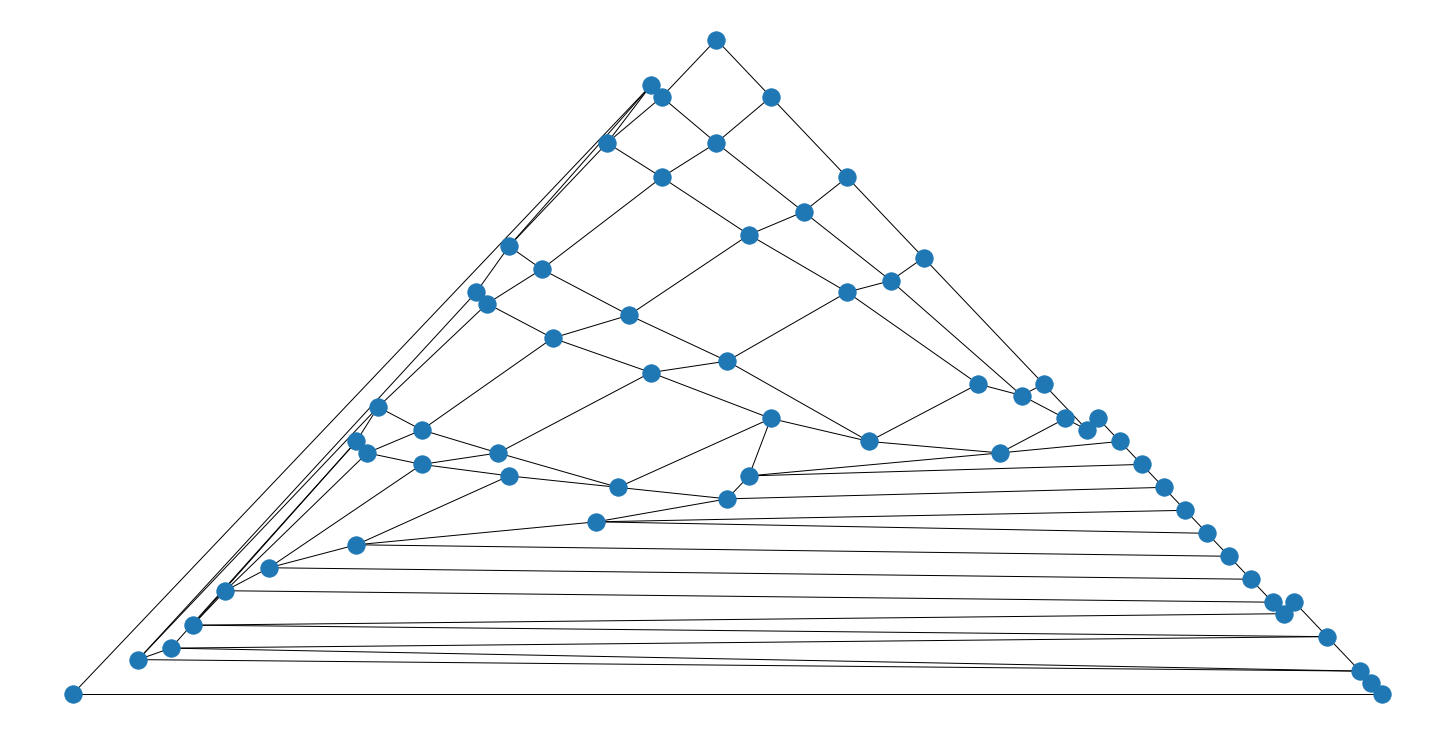

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

W_plot = W[0]
plt.figure(figsize = (20, 10))
G = nx.from_numpy_array(W_plot.numpy())
nx.draw_planar(G)

# FIND A WAY TO DRAW THE GRAPH BETTER

In [9]:
torch.__version__

'1.10.0'

## Creation of the dataset and dataloader

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
data_example = data_ex['de_movingAve2']
print(data_example.shape)
data_example = data_ex['de_movingAve1']
print(data_example.shape)

(62, 233, 5)
(62, 235, 5)


In [12]:
ttt = data_example[:, :, 0]
ttt = torch.FloatTensor(ttt)
torch.mean(ttt, 1)

tensor([26.5561, 27.2247, 26.8758, 26.4291, 26.4127, 26.5124, 25.5665, 26.0805,
        26.6996, 26.1163, 26.0040, 25.6098, 27.7226, 27.9743, 26.8461, 25.4917,
        25.4371, 26.4739, 25.4029, 24.7316, 25.5531, 25.7269, 27.5291, 25.8157,
        25.2200, 25.0360, 25.9591, 14.6803, 23.8669, 24.7903, 25.3112, 26.3336,
        26.1486, 25.0055, 24.4776, 23.9248, 14.5588, 25.7711, 26.4780, 26.3417,
        26.9905, 26.5443, 26.1485, 25.8919, 26.7255, 26.1698, 26.4846, 26.3106,
        26.3832, 26.4737, 26.5507, 26.0687, 26.0002, 25.6622, 26.7959, 26.1968,
        26.2504, 26.2034, 26.3934, 26.4136, 26.3797, 26.4576])

Not the same size we can make some padding to have the same.

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

In [14]:
def import_matfiles(path):
    list_mat_ex = os.listdir(path2)
    #list_mat_file contains all interessant files for our research
    list_mat_ex.remove('readme.txt')
    #list_mat_file contains all interessant files for our research
    label = list_mat_ex[-1]
    print(label)
    list_mat_ex.pop(-1)
    return list_mat_ex, label
    
def find_max_shape(datas, freq = None):
    #shape of data in datas (freq, nb channel, activity)
    if freq == None:
        max_ = datas[0].shape[2]
        for data in datas[1:]:
            act_shape = data.shape[2]
            if act_shape > max_ :
                max_ = act_shape
    else :
        #hape of data in datas (nb channel, activity)
        max_ = datas[0].shape[1]
        for data in datas[1:]:
            act_shape = data.shape[1]
            if act_shape > max_ :
                max_ = act_shape
    return max_  

def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x).type(torch.float32)

def datas_shaper(datas):
    res = []
    for data in datas:
        print(data.shape)
        res.append(x_shaper(data))
    return res 

def padd(datas, freq = None):
    #shape of data in datas (freq, nb channel activity)
    max_shape = find_max_shape(datas, freq =freq)
    res = []
    if freq == None :
        for data in datas:
            aux = torch.zeros((data.shape[0], data.shape[1], max_shape))
            if data.shape[2] < max_shape:
                add_shape = max_shape - data.shape[2]
                for freq in range(data.shape[0]):
                    pad_tensor = torch.zeros((data.shape[1], add_shape))
                    aux[freq, :, :] = torch.cat((data[freq, :, :], pad_tensor), dim=1)
                    aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    else :
        for data in datas:
            aux = torch.zeros((data.shape[0], max_shape))
            if data.shape[1] < max_shape:
                add_shape = max_shape - data.shape[1]
                pad_tensor = torch.zeros((data.shape[0], add_shape))
                aux = torch.cat((data, pad_tensor), dim=1)
                aux = aux.type(torch.float32)
                res.append(aux)
            else :
                res.append(data.type(torch.float32))
    return res

def normalize(x, freq = None):
    if freq == None:
        for frequencies in range(x.shape[0]):
            mean_ = torch.mean(x[frequencies, :, :], 1).reshape(-1, 1)
            std_ = torch.std(x[frequencies, : ,: ], 1).reshape(-1, 1)
            x[frequencies, :, :] = (x[frequencies, :, :] - mean_) / std_
            return x
    else :
        mean_ = torch.mean(x[freq, :, :], 1).reshape(-1, 1)
        std_ = torch.std(x[freq, : ,: ], 1).reshape(-1, 1)
        x[freq, :, :] = (x[freq, :, :] - mean_) / std_
        return x[freq, :, :]

In [15]:
import os
path2 = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'

In [16]:
l, label_ = import_matfiles(path2)
labels = loadmat(path2 + '\\' + label_)['label']

label.mat


In [41]:
#version to improve in a near future..
class SignalDataset(Dataset):
    def __init__(self, path, signals, subject_number, experiment_number, labels, smoothing_method, multifreq = False):
        """
        Args: 
            path: path to folder with all the .mat files of the dataset
            signals: feature that we want to extract
            subject_number: subject of the experimenr
            epxeriment_number: number of the experiment, like 0 week 1 week or 2 week 
            (MAYBE I MISUNDERSTOOD THIS PART READ AGAIN DATASET DETAILS)
            labels: labels list
            smoothing method: movingAve or LDS
        """
        list_file, _ = import_matfiles(path)
        #selection of interesting files that means the one related to the subject
        list_sub_file = []
        for file in list_file:
            num = file.split('_')[0]
            if int(num) == subject_number: 
                list_sub_file.append(file)
             
        working_file = list_sub_file[experiment_number]
        
        dic = loadmat(path + '\\' + working_file) 
        if smoothing_method == 'movingAve':
            smooth = signals.lower() + '_movingAve'
        elif smooting_method == 'LDS':
            smooth = signals.lower() + '_LDS'
        else :
            raise ValueError('Please select a good smoothing method: movingAve or LDS')
        
        #maybe a list is not the best tool to store it
        datas = []
        for k in range(15):
            sig = dic[smooth + str(k+1)]
            sig = x_shaper(sig)
            sig = normalize(sig, freq = 0) #change the freq if needed!!!!!!!!!!!!
            datas.append(sig)
            
        
        datas = padd(datas, freq = 0) #everything is happening in this function, the changement from Long to Float
                                    #and the slicing for the frequency we want

        labels = labels.reshape(-1, )
        labels = labels + 1 #sliding to use CrossEntropy Pytorch function
        labels = torch.from_numpy(labels)
                                  
                                  
        self.datas = datas
        self.labels = labels
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        return self.datas[idx], self.labels[idx].item()

In [42]:
path = r'C:\Users\harol\UsefulCode\CP_DSAI\Project\Dataset\SEED\ExtractedFeatures'
signals = 'de'
subject_number = 4
experiment_number = 0
labels = labels
smoothing_method = 'movingAve'
dataset = SignalDataset(path, signals, subject_number, experiment_number, labels, smoothing_method)
train_dataset, test_dataset = random_split(dataset, [9, 6])

label.mat


In [19]:
print(len(dataset))
print(len(train_dataset), len(test_dataset))

15
9 6


In [43]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [44]:
samp = next(iter(train_loader))
data, lab = samp
print(data.dtype)
print(data.shape)
print(lab)

torch.float32
torch.Size([1, 62, 265])
tensor([1])


## Model designing

In [22]:
#Test function
#L = laplacian(W)
#rescaled_laplacian(L)
#x = data_example
#x = x_shaper(x)
#x = x.type(torch.float32)
#theta = torch.rand(4)
#cheby_laplacian(L, x, theta, 4).shape

In [23]:
def D_matrix(W, multifreq = True):
    if multifreq:
        for freq in range(W.shape[0]):
            D[freq, :, :] = torch.diag(W[freq].sum(dim=-1))
        L = D - W
        L = L.type(torch.float32)
    else :
        D = torch.diag(W.sum(dim=-1))
    return D

def laplacian(W, multifreq = True): #here we calculate the non noramlized Laplacian matrix of the graph
    #multifreq means if we get the five frequencies in one or not
    L = D_matrix(W, multifreq = multifreq) - W
    L = L.type(torch.float32)
    return L


def x_shaper(x):
    """
    Arg: x as when it outcome from the dataset
    return: x as we wants tensor with (freq, nb_channel, activity)
    """
    x = x.transpose((2, 0, 1))
    return torch.from_numpy(x)


def cheby_laplacian(L, x, theta, multifreq = True):
    """
    Arg: Laplacian matrix, x the extracted signal, theta chebyshev coefficients, K the order of the polynom
    
    we suppose that x was transform to a tensor and that its shape was made as (freq, nb channel, activity)
    
    Return: the sum thetak*Tk(L)*x
    """
 
    y = torch.zeros_like(x) 
    K = theta.shape[0]
    
    if multifreq :
        L_tilde = torch.zeros_like(L) 
        for freq in range(L.shape[0]):
            #chebyshev polynoms is a basis in the domain [-1, 1]
            with torch.no_grad():
                eigenvalues, eigenvectors = torch.linalg.eig(L[freq, :, :])
                eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
                max_lambda = torch.max(eigenvalues).item() 
            L_tilde[freq, :, :] = ((2*L[freq, :, :]) / max_lambda) - torch.eye(L.shape[1])
            
            x_ = x[freq, :, :]
            L_ = L_tilde[freq, :, :]
            L_.type(torch.float32)

            x0_hat = x_
            x1_hat = torch.matmul(L_, x_)

            if K == 0:
                y[freq, :, :] = x0_hat*theta[0]
            if K == 1:
                y[freq, :, :] = x1_hat*theta[1] + x0_hat*theta[0]
            else:
                y[freq, :, :] = x0_hat*theta[0] + x1_hat*theta[1] 
                for k in range(2, K):
                    x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                    y[freq, :, :] += x2_hat*theta[k]
                    x1_hat = x2_hat
                    x0_hat = x1_hat
    else :
        with torch.no_grad():
            eigenvalues, eigenvectors = torch.linalg.eig(L)
            eigenvalues = eigenvalues.real #since L is symmetric real L is diagonalizable in the real space
            max_lambda = torch.max(eigenvalues).item() 
            
        #rescaling
        L_tilde = ((2*L) / max_lambda) - torch.eye(L.shape[0])
        
        #intialization of variables
        x_ = x
        L_ = L_tilde
        
        L_ = L_.type(torch.float32)

        x0_hat = x_
        x1_hat = torch.matmul(L_, x_)
        
        #calculus of Chebyshev polynoms
        if K == 0:
            y = x0_hat*theta[0]
        if K == 1:
            y = x1_hat*theta[1] + x0_hat*theta[0]
        else:
            y = x0_hat*theta[0] + x1_hat*theta[1] 
            for k in range(2, K):
                x2_hat = 2*torch.matmul(L_, x1_hat) - x0_hat
                y += x2_hat*theta[k]
                x1_hat = x2_hat
                x0_hat = x1_hat              
    return y

In [24]:
class DGCN1(nn.Module):

    def __init__(self, W, K, input_size, hidden_size, output_size):
        super().__init__()
        self.theta = nn.Parameter(torch.rand(K))
        self.W = nn.Parameter(W)
        self.K = K
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        #add some dropout !!!
        
    def forward(self, x):
        L = laplacian(self.W, multifreq = False) 
        X = cheby_laplacian(L, x, self.theta,  multifreq = False)
        # X shape (62, 'activity')
        X = F.relu(X)
        sh = X.shape[1]*X.shape[2] #there is the batch size at the beginning
        X = X.view(-1, sh)
        #shape (62.'activity', )
        X = self.l1(X)
        # (hidden_size, )
        X = F.relu(X)
        X = self.l2(X)
        # (3, )
        return X

In [94]:
class DGCNLayer(nn.Module):
    def __init__(self, W, K):
        super().__init__()
        self.W = nn.Parameter(W)
        self.theta = nn.Parameter(torch.FloatTensor(K, 1))
        self.theta = nn.init.uniform_(self.theta, 0, 10)
        
    def forward(self, x):
        L = laplacian(self.W, multifreq = False)
        X = cheby_laplacian(L, x, self.theta, multifreq = False)
        return X

In [149]:
class DGCN2(nn.Module):
    def __init__(self, W, K, input_size, hidden_size, output_size):
        super().__init__()
        self.GCNLayer1 = DGCNLayer(W, K)
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.GCNLayer1(x) 
        x = F.relu(x)
        x = x.view(-1, self.input_size)
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        return self.tanh(x)

In [150]:
62*265

16430

In [151]:
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True)

In [152]:
#theta = torch.rand(20)
model = DGCN2(W_, 15, 62*265, 50, 3).to(device)

In [153]:
print(model.GCNLayer1.theta)
print(model.GCNLayer1.W)

Parameter containing:
tensor([[1.6026],
        [2.7712],
        [0.2763],
        [2.9452],
        [9.5780],
        [4.5091],
        [7.7871],
        [9.7981],
        [5.2435],
        [5.2162],
        [5.3899],
        [9.8510],
        [7.5032],
        [1.6485],
        [0.7065]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]], requires_grad=True)


In [154]:
learning_rate = 0.05
#not all like the paper in testing  
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

In [155]:
print(model.parameters)
for param in model.parameters():
    print(type(param.data), param.size())

<bound method Module.parameters of DGCN2(
  (GCNLayer1): DGCNLayer()
  (l1): Linear(in_features=16430, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=3, bias=True)
  (tanh): Tanh()
)>
<class 'torch.Tensor'> torch.Size([62, 62])
<class 'torch.Tensor'> torch.Size([15, 1])
<class 'torch.Tensor'> torch.Size([50, 16430])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([3, 50])
<class 'torch.Tensor'> torch.Size([3])


In [156]:
dat1, lab1 = next(iter(train_loader))
pred1 = model(dat1)
print(lab1)
print(pred1)

tensor([1])
tensor([[0.1053, 0.7385, 0.8066]], grad_fn=<TanhBackward0>)


In [157]:
num_epochs = 500
alpha = 0.0005 #regularization parameter
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()        # Put the network into training mode
    
    for i, (signal, label_) in enumerate(train_loader):
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(signal)      # Do the forward pass
        loss = criterion(outputs, label_) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss

        #L1-Regularization
        l1_norm = sum(abs(p).sum() for p in model.parameters())
        loss = loss + alpha*l1_norm
        loss.backward()           # Calculate the gradients with help of back propagation
       #print('W')
       #print(model.GCNLayer1.W)
       #print(model.GCNLayer1.W.grad)
       #print('theta')
       #print(model.GCNLayer1.theta)
       #print(model.GCNLayer1.theta.grad)
        optimizer.step()          # Adjust the parameters based on the gradients
        
        
        # Record the correct predictions for training data 
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss / iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / float(len(train_dataset))))
   

    ############################
    # Test
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluate mode
    
    for i, (signal, label_) in enumerate(test_loader):
        
        outputs = model(signal)      # Do the forward pass
        loss += criterion(outputs, label_).item() # Calculate the loss
        
        # Record the correct predictions for training data
        predicted = torch.max(outputs.data, 1)[1]
        correct += (predicted == label_).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss / iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone()])[0]
    valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)
    
    if (epoch+1) % 5 == 0:
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
               %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
                 valid_loss[-1], valid_accuracy[-1]))

Epoch 5/500, Tr Loss: 1.7782, Tr Acc: 11.1111, Val Loss: 1.1647, Val Acc: 33.3333
Epoch 10/500, Tr Loss: 1.3868, Tr Acc: 44.4444, Val Loss: 0.9022, Val Acc: 83.3333
Epoch 15/500, Tr Loss: 1.4878, Tr Acc: 33.3333, Val Loss: 1.0852, Val Acc: 16.6667
Epoch 20/500, Tr Loss: 1.0091, Tr Acc: 22.2222, Val Loss: 1.5944, Val Acc: 0.0000
Epoch 25/500, Tr Loss: 1.3714, Tr Acc: 44.4444, Val Loss: 1.8698, Val Acc: 16.6667
Epoch 30/500, Tr Loss: 1.2806, Tr Acc: 55.5556, Val Loss: 1.6720, Val Acc: 16.6667
Epoch 35/500, Tr Loss: 1.4443, Tr Acc: 22.2222, Val Loss: 1.6304, Val Acc: 33.3333
Epoch 40/500, Tr Loss: 1.4671, Tr Acc: 33.3333, Val Loss: 2.2484, Val Acc: 16.6667
Epoch 45/500, Tr Loss: 1.0767, Tr Acc: 66.6667, Val Loss: 1.6922, Val Acc: 50.0000
Epoch 50/500, Tr Loss: 1.1909, Tr Acc: 44.4444, Val Loss: 1.6655, Val Acc: 16.6667
Epoch 55/500, Tr Loss: 0.8932, Tr Acc: 55.5556, Val Loss: 1.9191, Val Acc: 33.3333
Epoch 60/500, Tr Loss: 1.3686, Tr Acc: 44.4444, Val Loss: 2.0798, Val Acc: 16.6667
Epoch 

KeyboardInterrupt: 

In [ ]:
print(model.GCNLayer1.theta)
print(model.GCNLayer1.W)

In [71]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.drop = nn.Dropout(p=0.5)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.l1(x)
        x = self.tanh(x)
        x = self.drop(x)
        x = self.l2(x)
        return self.tanh(x)

In [72]:
W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True)
ln = LinearModel(62*265, 50, 3).to(device)
learning_rate = 0.01
#not all like the paper in testing  
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ln.parameters(), lr=learning_rate, momentum = 0.9) 

In [73]:
num_epochs = 1000
alpha = 0.001 #regularization parameter

for epoch in range(num_epochs):
    
    iter_loss = 0
    correct = 0
    ln.train()
    for i, (sig, label_) in enumerate(train_loader):  
               
        #print(ln(sig))
        # Forward pass
        output = ln(sig)
        #print(output)
        loss = criterion(output, label_) 
        l1_norm = sum(abs(p).sum() for p in ln.parameters())
        loss = loss + alpha*l1_norm
        predicted = torch.max(output.data, 1)[1]
        #print(predicted, label_)
        if predicted == label_:
            correct += 1
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        iter_loss += loss.item()
        optimizer.step()
    
    iter_loss_test = 0
    correct_test = 0
    ln.eval()
    for i, (sig, label_) in enumerate(test_loader):  

        output = ln(sig)
        #print(output)
        loss = criterion(output, label_)
        l1_norm = sum(abs(p).sum() for p in ln.parameters())
        loss = loss + alpha*l1_norm
        iter_loss_test += loss.item()
        predicted = torch.max(output.data, 1)[1]
        if predicted == label_:
            correct_test += 1
          
    if (epoch+1) % 5 == 0:
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Test Loss: %.4f, Acc Loss: %.4F'
               %(epoch+1, num_epochs, (iter_loss / len(train_loader))*100, (correct/ len(train_loader))*100, 
                  (iter_loss_test / len(test_loader))*100, (correct_test / len(test_loader))*100))
   

Epoch 5/1000, Tr Loss: 780.5238, Tr Acc: 77.7778, Test Loss: 839.9399, Acc Loss: 33.3333
Epoch 10/1000, Tr Loss: 554.6480, Tr Acc: 88.8889, Test Loss: 638.6455, Acc Loss: 33.3333
Epoch 15/1000, Tr Loss: 398.6136, Tr Acc: 100.0000, Test Loss: 519.2175, Acc Loss: 33.3333
Epoch 20/1000, Tr Loss: 340.5547, Tr Acc: 100.0000, Test Loss: 448.7107, Acc Loss: 33.3333
Epoch 25/1000, Tr Loss: 272.1448, Tr Acc: 100.0000, Test Loss: 395.4415, Acc Loss: 33.3333
Epoch 30/1000, Tr Loss: 208.2642, Tr Acc: 100.0000, Test Loss: 318.0248, Acc Loss: 33.3333
Epoch 35/1000, Tr Loss: 221.4194, Tr Acc: 100.0000, Test Loss: 348.7324, Acc Loss: 33.3333
Epoch 40/1000, Tr Loss: 178.0148, Tr Acc: 100.0000, Test Loss: 282.4220, Acc Loss: 33.3333
Epoch 45/1000, Tr Loss: 137.6944, Tr Acc: 100.0000, Test Loss: 243.2878, Acc Loss: 16.6667
Epoch 50/1000, Tr Loss: 92.5411, Tr Acc: 100.0000, Test Loss: 156.8611, Acc Loss: 33.3333
Epoch 55/1000, Tr Loss: 294.9681, Tr Acc: 100.0000, Test Loss: 426.6539, Acc Loss: 16.6667
Epo

KeyboardInterrupt: 

In [66]:
5/6

0.8333333333333334

In [80]:
ln.l1.bias

Parameter containing:
tensor([-3.7006e-01, -4.0848e-01, -4.1076e-02, -1.2139e-01,  2.9683e-01,
        -3.9594e-01, -1.3384e-02,  3.4198e-02, -2.5771e-01, -2.2223e-01,
         1.2833e-01, -1.4781e-01, -1.9355e+01, -3.2538e-01, -3.4420e-01,
        -3.3618e-01, -6.7057e+00, -3.6416e-02,  3.6272e-03, -9.8468e-02,
        -2.6229e-01, -1.7947e-01, -4.4616e-02, -4.0054e-01, -3.0271e-01,
         5.7226e-01, -1.7374e-01,  1.7011e-01, -3.2431e-01,  3.7344e-01,
        -9.9082e-02,  4.6870e-01, -5.3800e-02, -2.2149e-01,  2.0660e-01,
         5.7199e-01, -9.0686e-01, -9.2436e-01, -2.5882e-01, -5.9203e-01,
        -1.9889e-01, -3.7286e-01, -7.2462e-01, -9.8542e-01, -1.2773e+00,
        -4.7272e-01,  3.1191e-01, -8.3016e-01, -3.9383e-01,  4.8560e-01],
       requires_grad=True)

## Model performance according to the power K 

In [ ]:
learning_rate = 0.01
#not all like the paper in testing  
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9) 

input_size = 62*265 #change for all subjects of the experiment!!!
hidden_size = 50
output_size = 3

In [61]:
#we don't care about the initialization of theta since all thetas will be initialized with the same way uniformly
perf_train_loss = []
perf_test_loss = []
perf_train_acc = []
perf_test_acc = []


num_epochs = 200
alpha = 0.0001 #regularization parameter
for pow_ in range(2, 21):
    W_ = W[0].type(torch.float32).clone().detach().requires_grad_(True)
    model = DGCN2(W_, pow_, input_size, hidden_size, output_size)
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    
    for epoch in range(num_epochs):
    
        ############################
        # Train
        ############################
    
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()        # Put the network into training mode

        for i, (signal, label_) in enumerate(train_loader):

            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = model(signal)      # Do the forward pass
            loss = criterion(outputs, label_) # Calculate the loss
            iter_loss += loss.item() # Accumulate the loss

            #L1-Regularization
            l1_norm = sum(abs(p).sum() for p in ln.parameters())
            loss = loss + alpha*l1_norm
            loss.backward()           # Calculate the gradients with help of back propagation
            optimizer.step()          # Adjust the parameters based on the gradients

            # Record the correct predictions for training data 
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()
            iterations += 1

        # Record the training loss
        train_loss.append(iter_loss / iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / float(len(train_dataset))))


        ############################
        # Test
        ############################

        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()                    # Put the network into evaluate mode

        for i, (signal, label_) in enumerate(test_loader):

            outputs = model(signal)      # Do the forward pass
            loss += criterion(outputs, label_).item() # Calculate the loss

            # Record the correct predictions for training data
            predicted = torch.max(outputs.data, 1)[1]
            correct += (predicted == label_).sum()

            iterations += 1

        # Record the validation loss
        valid_loss.append(loss / iterations)
        # Record the validation accuracy
        correct_scalar = np.array([correct.clone()])[0]
        valid_accuracy.append(correct_scalar.item() / len(test_dataset) * 100.0)

        if (epoch+1) % 50 == 0:
            print ('Order %d Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                   %(pow_, epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
                     valid_loss[-1], valid_accuracy[-1]))
        perf_train_loss.append(train_loss)
        perf_test_loss.append(valid_loss)
        perf_train_acc.append(train_accuracy)
        perf_test_acc.append(valid_accuracy)
    
    

NameError: name 'input_size' is not defined

In [ ]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 1, figsize = (15, 25))

for k in range(len(perf_train_loss)):
    ax[0].plot(x_plot, perf_train_loss[k], label = 'order' + str(k))
    ax[1].plot(x_plot, perf_test_loss[k], label = 'order' + str(k))
    
    ax[0].set_title('Train set')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    
    ax[1].set_title('Test set')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

plt.legend(loc='upper right')   
plt.show()

In [ ]:
x_plot = np.arange(num_epochs)
fig, ax = plt.subplots(2, 1, figsize = (15, 25))
for k in range(len(perf_train_loss)):
    ax[0].plot(x_plot, perf_train_acc[k], label = 'order' + str(k))
    ax[1].plot(x_plot, perf_test_acc[k], label = 'order' + str(k))
    
    ax[0].set_title('Train set')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Test set')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
  
plt.legend()
plt.show()